## Data from sediment 
This notebook will focus on microbiome data collected from sediment of watertanks holding fish with different probiotic supplementation added

In [60]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from functions import *
from sklearn.preprocessing import LabelEncoder


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Sed/sed_bacteria_full_feature_table.csv')
print(df.shape)
print(len(df["pond"].unique()))
df.head()



(50, 228)
25


,pond,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sed_S10,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sed_S11,81.0,21.0,29.0,90.0,NaN,8.0,10.0,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sed_S11,3.0,13.0,18.0,3.0,NaN,3.0,18.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sed_S12,171.0,67.0,109.0,76.0,23.0,31.0,NaN,1.0,352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After the data look and checkup we can see that the dataset cosists of 227 bacteria famillies (columns) which we will treat as features, and 50 rows holding 25 unique values each of those represents one pond, ponds are divided into 5 different experimental setups we will have to decode that. Also there are two values per pond which indicate two points in time. We will perform classification between those two points to see if model is able to notice any significant changes and if it does use feature selection methods to see which bacteria is impacted by time alone regardless of supplementation. Later we will perform classification based on different experimental setups on both timepoints (one timepoint at the time) to see if there are changes between those.  

In [3]:
df.fillna(0, inplace=True)
df.describe()

,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__uncultured,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,87.880000,88.440000,238.540000,60.020000,13.140000,14.420000,17.660000,7.420000,103.480000,39.040000,...,0.440000,0.720000,0.460000,0.30000,0.900000,0.260000,0.240000,0.220000,0.220000,0.200000
std,72.437909,65.694767,359.278484,40.221068,21.783733,21.364753,24.860927,11.510581,127.867636,31.416855,...,2.214608,4.549232,3.252691,2.12132,4.704535,1.838478,1.697056,1.555635,1.555635,1.414214
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,34.500000,24.000000,33.250000,0.000000,0.000000,0.000000,0.000000,3.250000,10.250000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,82.000000,73.500000,88.500000,56.500000,4.000000,2.000000,6.000000,1.500000,51.000000,36.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,126.250000,121.000000,297.000000,80.000000,19.500000,22.000000,28.000000,10.000000,196.750000,56.750000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,368.000000,256.000000,1898.000000,170.000000,103.000000,86.000000,113.000000,52.000000,463.000000,130.000000,...,13.000000,32.000000,23.000000,15.00000,30.000000,13.000000,12.000000,11.000000,11.000000,10.000000


In [4]:
classes = np.tile([0, 1], 25)
#df.drop(columns=["class"], inplace=True)
df.insert(1,"class_timepoint",  classes)

In [5]:
target = ["class_timepoint"]
predictors = list(set(df.columns) - set(["class_timepoint", "pond"]))


In [6]:
df_norm = df.copy()
X_norm = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df_norm[predictors] = X_norm


In [7]:
X=df_norm[predictors].values
y=df["class_timepoint"].values
yt = keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(35, 227) (15, 227) (35, 2) (15, 2)


Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

### Modeling timepoints only

#### Model building


In [8]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
#model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(2, activation ='softmax'))

model1.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,946 (292.76 KB)

 Trainable params: 74,946 (292.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Model compiling

In [9]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

#### Model fitting

In [10]:
history1=model1.fit(X_train, y_train, epochs = 500, verbose = 1, shuffle = True, validation_data=(X_test, y_test))


Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.4211 - loss: 0.7336 - val_accuracy: 0.6000 - val_loss: 0.6833
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3726 - loss: 0.7453 - val_accuracy: 0.6000 - val_loss: 0.6832
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5095 - loss: 0.7133 - val_accuracy: 0.6000 - val_loss: 0.6829
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4696 - loss: 0.7193 - val_accuracy: 0.6000 - val_loss: 0.6829
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4420 - loss: 0.7292 - val_accuracy: 0.6000 - val_loss: 0.6830
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4610 - loss: 0.7193 - val_accuracy: 0.5333 - val_loss: 0.6830
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4420 - loss: 0.6991 - val_accuracy: 0.5333 - val_loss: 0.6832
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5390 - loss: 0.6794 - val_accuracy: 0.5333 - val_loss

### Model evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5333 - loss: 1.6120
[1.611951470375061, 0.5333333611488342]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted values: [0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
True values: [1 1 0 0 0 1 1 1 1 1 1 0 0 0 0]


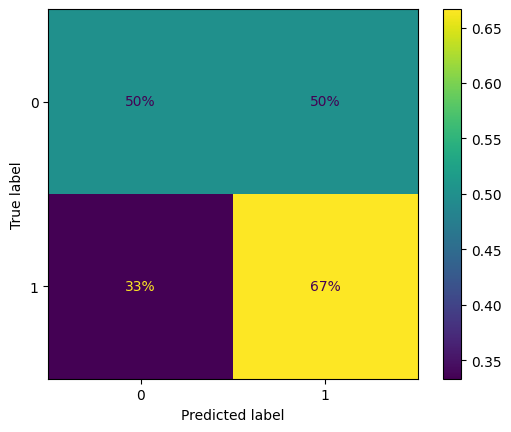

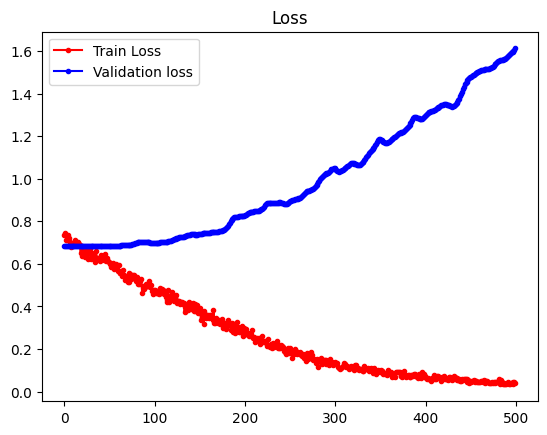

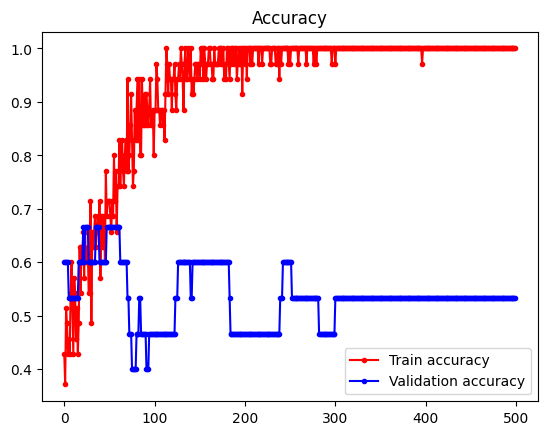

In [11]:
evaluate_model(model1, history1, X_test, y_test)

We can see that model is not suffering from overfitting problem, however the results are bad with accuracy barely exceeding 0.6 where 0.5 is baseline for randomly assigning classes. Confusion Matrix also reveals that model is not far from random choices, this could mean two things:
1. Model is bad 
2. There are no differencecs to be found 

As we checked different models and it is suspected that the change in time is depended on different probiotic supplementation we will not go down this path, second thing we will check in downstream analysys.

### Modeling differences between Classes for both timepoints at the same time

In [12]:

def pond_decoder(x,codes):
    
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

In [13]:
df.head()

,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
len(predictors)

227

In [36]:
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))
df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


C:\Users\marek\AppData\Local\Temp\ipykernel_35256\2389808530.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


In [16]:
X = df[predictors].values
y=df["class_pond"].values
yt = keras.utils.to_categorical(y, 5)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(35, 227) (15, 227) (35, 5) (15, 5)


In [17]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,941 (296.64 KB)

 Trainable params: 75,941 (296.64 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [19]:
history2=model2.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.1958 - loss: 36.0938 - val_accuracy: 0.2000 - val_loss: 31.9148
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1750 - loss: 31.3693 - val_accuracy: 0.2000 - val_loss: 28.4901
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2253 - loss: 26.0304 - val_accuracy: 0.1333 - val_loss: 25.9605
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2548 - loss: 22.5759 - val_accuracy: 0.0667 - val_loss: 23.8889
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2842 - loss: 20.3012 - val_accuracy: 0.0667 - val_loss: 22.2312
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2946 - loss: 16.8431 - val_accuracy: 0.0667 - val_loss: 20.8450
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3137 - loss: 15.9433 - val_accuracy: 0.1333 - val_loss: 19.4549
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3327 - loss: 14.7782 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2000 - loss: 8.6253
[8.625341415405273, 0.20000000298023224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted values: [4 1 4 4 1 4 1 1 4 3 4 2 4 1 1]
True values: [2 0 0 4 2 3 3 3 4 1 2 0 1 1 4]


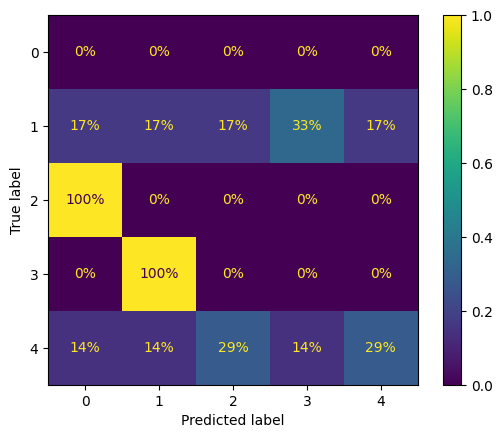

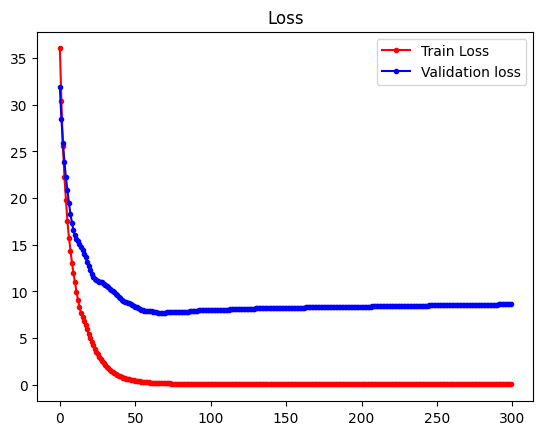

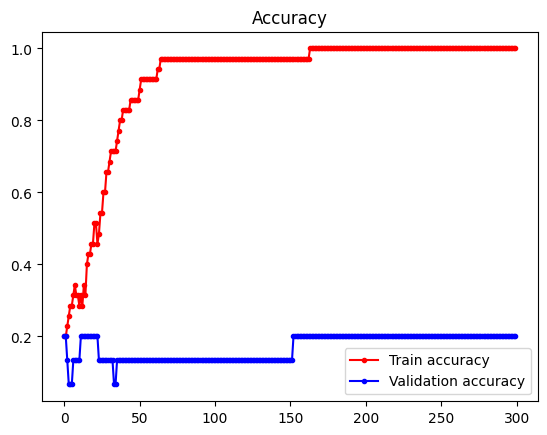

In [20]:
evaluate_model(model2, history2, X_test, y_test)

We can see here that there is problem with overfitting and becouse that there is not much viable learining happening after around epoch 80+ and once again accuracy is below random threshold of 0.2. The cause of that is probably becouse its hard for model to see differences in class only when timepoint probably plays viable role in change of bacteria abundance. We will now try to classify in only one timepoint for that we will chose second timepoint as that is the one where supplementation could have chance to impact microbiome. Issue with that is we will halve our dataset which is already small (from 50 to 25 samples).

### Modeling class differences in second timepoint

In [37]:
df_second_tp = df_norm[df_norm["class_timepoint"]==1]
print(df_second_tp.shape)
df_second_tp.head()

(25, 230)


,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
1,Sed_S10,1,0.048913,0.585938,0.005269,0.758824,0.000000,0.000000,0.265487,0.615385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Sed_S11,1,0.008152,0.050781,0.009484,0.017647,0.000000,0.034884,0.159292,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,Sed_S12,1,0.127717,0.343750,0.012645,0.247059,0.000000,0.023256,0.000000,0.173077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,Sed_S13,1,0.380435,0.441406,0.197050,0.394118,0.029126,1.000000,0.000000,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
9,Sed_S14,1,0.491848,0.859375,0.131191,0.276471,0.223301,0.488372,0.353982,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [38]:
X=df_second_tp[predictors].values
y=df_second_tp["class_pond"].values
yt = keras.utils.to_categorical(y, 5)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(15, 227) (10, 227) (15, 5) (10, 5)


In [39]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(5, activation ='softmax'))

model3.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,941 (296.64 KB)

 Trainable params: 75,941 (296.64 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [41]:
history3=model3.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step - accuracy: 0.1333 - loss: 1.6269 - val_accuracy: 0.2000 - val_loss: 1.6826
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2000 - loss: 1.6230 - val_accuracy: 0.2000 - val_loss: 1.6824
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2000 - loss: 1.6143 - val_accuracy: 0.2000 - val_loss: 1.6823
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1333 - loss: 1.6311 - val_accuracy: 0.2000 - val_loss: 1.6822
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2667 - loss: 1.5897 - val_accuracy: 0.2000 - val_loss: 1.6818
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3333 - loss: 1.5781 - val_accuracy: 0.2000 - val_loss: 1.6815
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2000 - loss: 1.5958 - val_accuracy: 0.2000 - val_loss: 1.6813
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2667 - loss: 1.5579 - val_accuracy: 0.2000 - val_loss

In [42]:
predictions = model3.predict(X_test)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[[0.22459696 0.23372327 0.29466304 0.11707688 0.12993981]
 [0.2770792  0.27077994 0.24334131 0.10237714 0.10642242]
 [0.09994592 0.34626326 0.13153236 0.04471973 0.3775387 ]
 [0.23991852 0.21768045 0.16203947 0.14264308 0.23771848]
 [0.10454601 0.3222966  0.15819497 0.12671499 0.28824744]
 [0.20413873 0.30296895 0.22154449 0.13952745 0.1318204 ]
 [0.2045346  0.30264518 0.24557342 0.11981762 0.12742917]
 [0.08480947 0.37979767 0.16332297 0.11739989 0.25467   ]
 [0.18744768 0.31275475 0.17185046 0.13951255 0.18843453]
 [0.23027141 0.24295653 0.15749332 0.15409319 0.21518551]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1000 - loss: 1.8238
[1.823818564414978, 0.10000000149011612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted values: [2 0 4 0 1 1 1 1 1 1]
True values: [1 2 2 4 0 4 3 0 1 3]


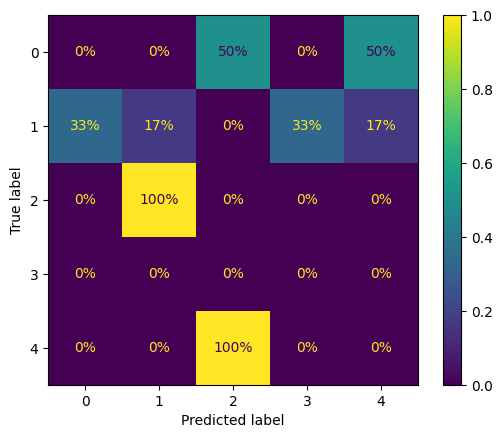

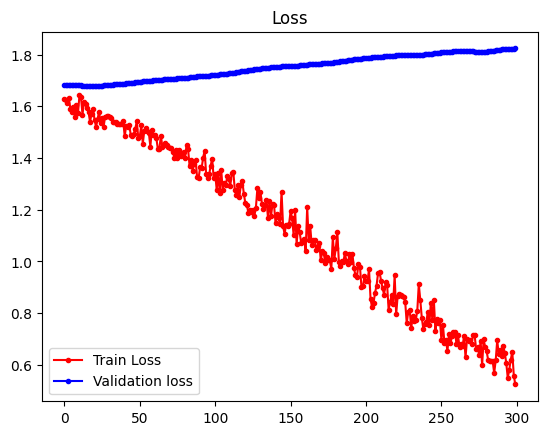

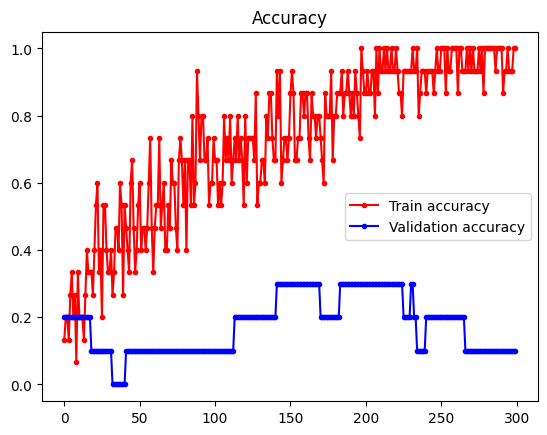

In [43]:
evaluate_model(model3, history3, X_test, y_test)

From those results we can clearly see that its very hard to work with neural networks on such small sample sizes even when we choose to have 20 samples aviable for training the results were bad. We can also check how the model behaves when we split data into 10 classes (timepoint*experimetnal_setup)

In [44]:
df.head()

,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [48]:
df["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)
df_norm["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)

C:\Users\marek\AppData\Local\Temp\ipykernel_35256\1246733335.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)


In [47]:
len(df["class_timepoint*pond"].unique())

10

In [62]:
X=df[predictors].values
y=df["class_timepoint*pond"].values
y = LabelEncoder().fit_transform(y)
y
yt = keras.utils.to_categorical(y, 10)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(40, 227) (10, 227) (40, 10) (10, 10)


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])